In [165]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

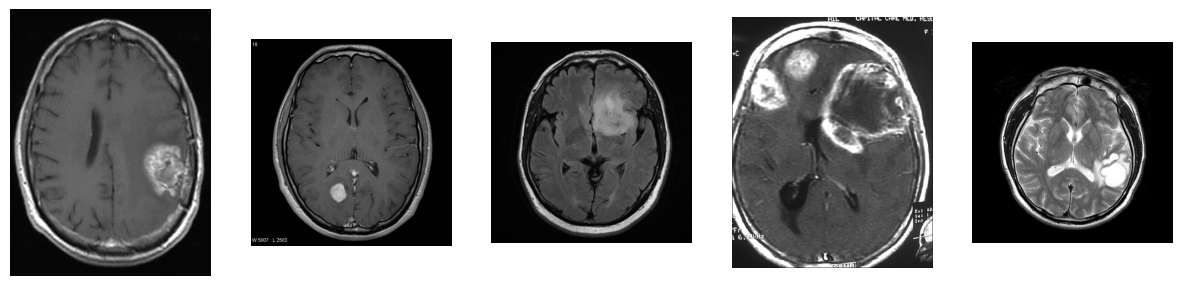

In [166]:
# Load sample images
image_dir = "dataset/yes"
sample_images = os.listdir(image_dir)[:5]

# Show images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, img_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(image_dir, img_name), cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.show()

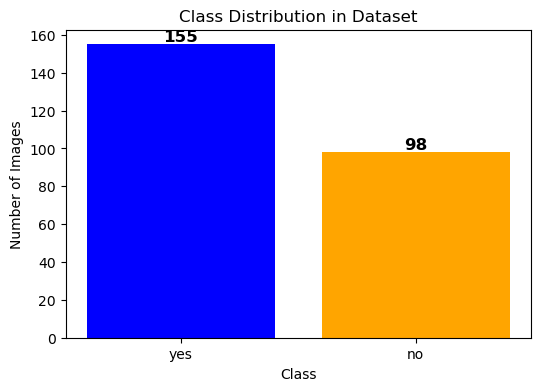

In [167]:
# Define dataset paths
dataset_path = "dataset"
categories = ["yes", "no"]

# Count the number of images in each category
class_counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}

# Plot class distribution with counts
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])

# Annotate bars with counts
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

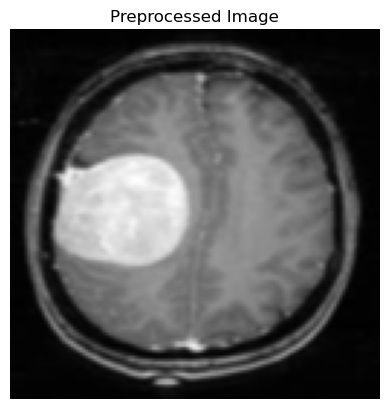

In [168]:
# Define preprocessing function
def preprocess_image(image_path, target_size=(128,128)):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur for noise reduction
    img = cv2.GaussianBlur(img, (5,5), 0)

    # Resize image
    img = cv2.resize(img, target_size)

    # Normalize pixel values
    img = img / 255.0  # Normalization to [0,1]

    return img

# Load and preprocess an example image
image_path = "dataset/yes/Y1.jpg"
processed_img = preprocess_image(image_path)

# Display preprocessed image
plt.imshow(processed_img, cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

In [169]:
# Load a sample image
img_path = "dataset/yes/Y1.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))
img = np.expand_dims(img, axis=0)  # Expand dimensions to match batch input

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values
    rotation_range=20,   # Random rotation between -20 and 20 degrees
    width_shift_range=0.2,  # Random horizontal shift up to 20% of width
    height_shift_range=0.2, # Random vertical shift up to 20% of height
    zoom_range=0.2,       # Random zooming within 20%
    horizontal_flip=True,  # Randomly flip image horizontally
    validation_split=0.2  # Split dataset into training and validation
)

In [170]:
# Define dataset directory
dataset_dir = 'dataset'  # Change this to your actual dataset path

# Initialize lists for image paths and labels
image_paths = []
labels = []

# Loop through the "yes" and "no" folders
for label, folder in enumerate(['yes', 'no']):
    folder_path = os.path.join(dataset_dir, folder)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith((".jpg", ".png", ".jpeg")):  # Check for image files
                image_paths.append(os.path.join(folder_path, file))
                labels.append(1 if folder == 'yes' else 0)  # Assign label: 1 for tumor, 0 for no tumor

# Shuffle the dataset to ensure randomness
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Print some examples to check if paths and labels are correct
print(image_paths[:10], labels[:10])

['dataset/yes/Y70.jpg', 'dataset/yes/Y92.jpg', 'dataset/yes/Y103.jpg', 'dataset/no/No12.jpg', 'dataset/yes/Y73.jpg', 'dataset/yes/Y169.jpg', 'dataset/no/38 no.jpg', 'dataset/yes/Y41.jpg', 'dataset/yes/Y107.jpg', 'dataset/no/No20.jpg'] [1, 1, 1, 0, 1, 1, 0, 1, 1, 0]


In [171]:
# Convert integer labels to string labels
labels_str = ["yes" if label == 1 else "no" for label in labels]

# Create DataFrame with string labels
df = pd.DataFrame({"filename": image_paths, "label": labels_str})

# Image size and batch size
img_size = (128, 128)
batch_size = 32  # Recommended batch size

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values
    rotation_range=20,    # Random rotation between -20 and 20 degrees
    width_shift_range=0.2, # Random horizontal shift up to 20% of width
    height_shift_range=0.2, # Random vertical shift up to 20% of height
    zoom_range=0.2,       # Random zooming within 20%
    horizontal_flip=True,  # Randomly flip image horizontally
    validation_split=0.2   # Splitting into training and validation
)

# No augmentation for validation, only rescaling
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)

# Load validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=False  # Do not shuffle validation data
)

# Check the number of images in each set
print(f"Training samples: {train_generator.samples}, Validation samples: {val_generator.samples}")

Found 144 validated image filenames belonging to 2 classes.
Found 35 validated image filenames belonging to 2 classes.
Training samples: 144, Validation samples: 35


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.5178 - loss: 1.0797 - val_accuracy: 0.5429 - val_loss: 0.8426
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5258 - loss: 0.8454 - val_accuracy: 0.5714 - val_loss: 0.6412
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.4944 - loss: 0.6910 - val_accuracy: 0.5143 - val_loss: 0.6427
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5697 - loss: 0.6751 - val_accuracy: 0.8000 - val_loss: 0.5850
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6224 - loss: 0.6716 - val_accuracy: 0.7429 - val_loss: 0.5473
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6144 - loss: 0.6511 - val_accuracy: 0.7429 - val_loss: 0.4836
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6386 - loss: 0.6299 - val_accuracy: 0.8000 - val_loss: 0.3959
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5926 - loss: 0.6958 - val_accuracy: 0.6857 - val_loss:

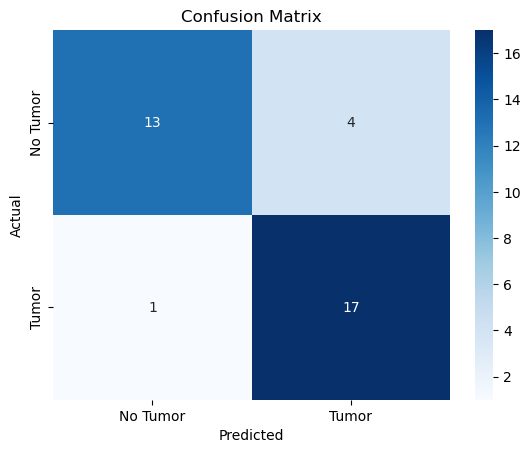

True Positives: 17
False Positives: 4
False Negatives: 1
True Negatives: 13
Precision: 0.8095
Accuracy: 0.8571
Sensitivity (Recall): 0.9444


In [172]:
# Build CNN Model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
cnn_history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# Evaluate model
cnn_predictions = (cnn_model.predict(val_generator) > 0.5).astype("int32")

# Compute confusion matrix
cnn_cm = confusion_matrix(val_generator.classes, cnn_predictions)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Extract TP, FP, FN, TN
cnn_TN, cnn_FP, cnn_FN, cnn_TP = cnn_cm.ravel()
cnn_precision = precision_score(val_generator.classes, cnn_predictions)
cnn_accuracy = accuracy_score(val_generator.classes, cnn_predictions)
cnn_recall = recall_score(val_generator.classes, cnn_predictions)
print(f"True Positives: {cnn_TP}")
print(f"False Positives: {cnn_FP}")
print(f"False Negatives: {cnn_FN}")
print(f"True Negatives: {cnn_TN}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Accuracy: {cnn_accuracy:.4f}")
print(f"Sensitivity (Recall): {cnn_recall:.4f}")

In [173]:
# Build a Deeper CNN Model
deep_cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
deep_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Early Stopping to Prevent Overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class Weights: {0: 0.96, 1: 1.0434782608695652}
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - accuracy: 0.5125 - loss: 1.2774 - val_accuracy: 0.4571 - val_loss: 0.6930
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.5566 - loss: 1.1743 - val_accuracy: 0.7714 - val_loss: 0.6912
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.6306 - loss: 1.0101 - val_accuracy: 0.6857 - val_loss: 0.6913
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.5996 - loss: 0.9139 - val_accuracy: 0.4857 - val_loss: 0.6924
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.6007 - loss: 0.9771 - val_accuracy: 0.4857 - val_loss: 0.6928
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.6406 - loss: 0.8018 - val_accuracy: 0.4857 - val_loss: 0.6946
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.7574 - loss: 0.5980 - val_accuracy: 0.4857 - val_loss: 0.6986
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


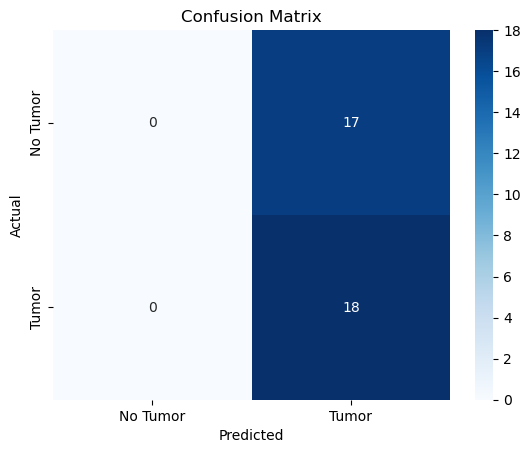

True Positives: 18
False Positives: 17
False Negatives: 0
True Negatives: 0
Precision: 0.5143
Accuracy: 0.5143
Sensitivity (Recall): 1.0000


In [174]:
class_labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# Train the Model
epochs = 20
history = deep_cnn_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs, 
    class_weight=class_weight_dict, 
    callbacks=[early_stopping]
)

# Predictions with Lower Threshold (Better Sensitivity)
predictions = (deep_cnn_model.predict(val_generator) > 0.3).astype("int32")

# Compute Confusion Matrix
cm = confusion_matrix(val_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print Performance Metrics
deep_cnn_TN, deep_cnn_FP, deep_cnn_FN, deep_cnn_TP = cm.ravel()
deep_cnn_precision = precision_score(val_generator.classes, predictions)
deep_cnn_accuracy = accuracy_score(val_generator.classes, predictions)
deep_cnn_recall = recall_score(val_generator.classes, predictions)

print(f"True Positives: {deep_cnn_TP}")
print(f"False Positives: {deep_cnn_FP}")
print(f"False Negatives: {deep_cnn_FN}")
print(f"True Negatives: {deep_cnn_TN}")
print(f"Precision: {deep_cnn_precision:.4f}")
print(f"Accuracy: {deep_cnn_accuracy:.4f}")
print(f"Sensitivity (Recall): {deep_cnn_recall:.4f}")

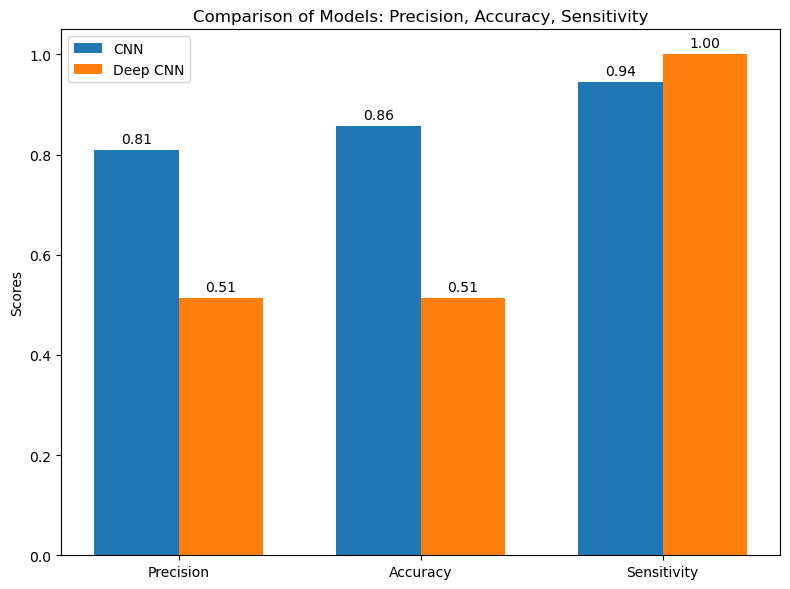

In [175]:
cnn_values = {'Precision': cnn_precision, 'Accuracy': cnn_accuracy, 'Sensitivity': cnn_recall}
deep_cnn_values = {'Precision': deep_cnn_precision, 'Accuracy': deep_cnn_accuracy, 'Sensitivity': deep_cnn_recall}

# Labels for the metrics
metrics = ['Precision', 'Accuracy', 'Sensitivity']

# Values for each model
cnn_model = [cnn_values['Precision'], cnn_values['Accuracy'], cnn_values['Sensitivity']]
deep_cnn_model = [deep_cnn_values['Precision'], deep_cnn_values['Accuracy'], deep_cnn_values['Sensitivity']]

# X-axis positions for the bars
x = np.arange(len(metrics))

# Width of bars
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars for both models
rects1 = ax.bar(x - width/2, cnn_model, width, label='CNN')
rects2 = ax.bar(x + width/2, deep_cnn_model, width, label='Deep CNN')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models: Precision, Accuracy, Sensitivity')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show value labels on top of bars
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Add value labels for each model
add_value_labels(rects1)
add_value_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()